In [1]:
from __future__ import absolute_import, division, print_function

import functools
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import tensorflow as tf
from pprint import pprint

In [2]:
tf.__version__

'2.0.0'

In [3]:
tf.executing_eagerly()

True

In [4]:
tf.test.is_gpu_available()

False

## Generating Discrete Harmonic Functions on the Square

The Harmonic functions on the square A of size N are those functions that satisfy:
$$f(i, j) = \frac{1}{4}\bigg(f(i-1, j) + f(i+1, j) + f(i,j-1) + f(i,j+1)\bigg)$$
for all $i,j \in \{1, 2, ..., N-1\}$.  These functions are uniquely determined by their values on the boundary of the square: $i\in\{0,N\}\text{ or }j\in\{0,N\}$.  

What follows is a summary of http://www.math.uchicago.edu/~lawler/reu.pdf, section 1.5.

Let $e_k$ refer to the function defined on $\partial A$ that is equal to 1 at the $k$th position at the bottom of the square and is equal 0 elsewhere.  Then the harmonic function on the interior of the square that is equal to $e_k$ on the boundary is given by:
$$H_{(N, e_k)}(x_1, x_2) = \frac{2}{N-1}\sum_{j=1}^{N-1}\frac{1}{\sinh(\beta_j)}\sin\left(\frac{j\pi k}{N}\right)\sinh\left(\frac{\beta_jx_1}{N}\right)\sin\left(\frac{j\pi x_2}{N}\right)$$
where $\beta_j\text{ for }j\in\{1, 2, ..., N-1\}$ solves:
$$ \cosh\left(\frac{\beta_j}{N}\right) + \cos\left(\frac{j\pi}{N}\right) = 2$$
These functions, combined with similar functions for the other sides of the square, form a basis for the space of all harmonic functions on the interior of the square.  This is implemented below.

In [5]:
harmonic_basis_cache={}

def generate_beta(n):
    return [n*(np.arccosh(2-np.cos(j*np.pi/n))) for j in range(1,n)]
  
def poisson_kernel_square_raw(n, y, x_1, x_2):
    beta = generate_beta(n)
    h = [np.sinh(beta[j-1] * x_1 / n) 
        * np.sin(j * np.pi * x_2 / n) for j in range(1, n)]
    c = [1/np.sinh(beta[j-1]) 
        * np.sin(j * np.pi * y / n) for j in range(1, n)]
    return 2/(n) * sum([c[j-1] * h[j-1] for j in range(1, n)])
  
def poisson_kernel_square(n, y):
    return lambda x_1, x_2: poisson_kernel_square_raw(n, y, x_1, x_2)
  
    
def harmonic_basis(n, k):
    if (n,k) in harmonic_basis_cache.keys():
        return harmonic_basis_cache[n,k]
    x = np.zeros(shape=[n+1, n+1])
    x[n,k] = 1
    H = poisson_kernel_square(n, k)
    for i in range(1, n):
        for j in range(1, n):
            x[i, j] = H(i, j)
    harmonic_basis_cache[n,k] = x
    return x
  
# This is O(n^3) at the moment.
# This is due to each of n basis functions taking O(n^2) steps to compute.
# Can this be improved?  Do we care?
def generate_harmonic_one_side(n, y, side='lower'):
    lower = np.sum([y[j-1] * harmonic_basis(n,j) for j in range(1, n)], axis=0)
    if side == 'upper':
        return np.flip(lower, axis=0)
    if side == 'left':
        return np.rot90(lower, k=3)
    if side == 'right':
        return np.rot90(np.flip(lower, axis=0), k=3)
    if side == 'lower':
        return lower

def generate_harmonic(n, y):
    """Here y specifies the entire boundary, going in order of upper, left, right, lower."""
    upper = generate_harmonic_one_side(n, y[:n-1], side='upper')
    left = generate_harmonic_one_side(n, y[n-1:2*n-2], side='left')
    right = generate_harmonic_one_side(n, y[2*n-2:3*n-3], side='right')
    lower = generate_harmonic_one_side(n, y[3*n-3:], side='lower')
    return upper + left + right + lower

In [6]:
def is_harmonic_at_point(x, i, j, tol=.000001, verbose=False):
    diff = np.abs(x[i, j] - np.mean([x[i-1,j], x[i+1,j], x[i,j-1], x[i,j+1]])) 
    if verbose:
        print("|{} - {}| = {}".format(x[i,j], 
                                      np.mean([x[i-1,j], x[i+1,j], x[i,j-1], x[i,j+1]]), 
                                      diff))
    return diff <= tol
  
def is_harmonic(x, n, tol=.000001, verbose=False):
    for i in range(1, n):
        for j in range(1, n):
            if not is_harmonic_at_point(x, i, j, tol=tol, verbose=verbose):
                if verbose:
                    print((i,j))
                return False
    return True

## Generating Non-Harmonic Functions.

The question of what to use as a negative for the model deserves a lot of thought.  At present I have two approaches: 

In the first approach, I use \\((N+1)^2\\) independent Gaussian random variables to generate non-harmonic functions.  The likelihood that these will be harmonic is negligible.  

In the second approach I generate a harmonic function, and add a gaussian density to the result.  Since the gaussian is not harmonic (it in particular violates the maximum modulus principle), the resulting sum is not harmonic.

In [7]:
def generate_nonharmonic(n):
    x = np.random.randn(n+1,n+1)
    x[0,0] = 0.
    x[0,n] = 0.
    x[n,0] = 0.
    x[n,n] = 0.
    return x

In [8]:
grv_cache={}

# This is slow, need to make better use of numpy to 
# generate these, possibly with memoization as above.
def generate_gaussian(n, strength):
    mean = np.random.randint(1,n, size=2)
    cov = (n/2 - .5) * np.random.random(size=2) + .5
    amplitude = strength * np.random.choice([1,-1])
    rv = multivariate_normal(mean=mean, cov=cov)
    x = np.zeros((n+1,n+1))
    for i in range(1,n):
        for j in range(1,n):
            x[i,j] = rv.pdf((i,j))/rv.pdf(mean)
    return amplitude * x

def generate_harmonic_plus_noise(n, y, strength=.1):
    harmonic = generate_harmonic(n, y)
    output = harmonic + generate_gaussian(n, strength=strength)
    return output

In [9]:
def visualize(examples, n, cmap='cividis'):
    num_examples = len(examples)
    fig, axes = plt.subplots(1, num_examples, figsize=(n+1,n+1))
    if num_examples == 1:
        axes.imshow(examples[0], cmap=cmap)
        axes.axis('off')
        plt.show()
        return
    axes = axes.flatten()
    for x, ax in zip(examples, axes):
        ax.imshow(x, cmap=cmap)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

## Visualizing the Data

Here we can note the triviality, for large $N$, of distinguishing harmonic functions from random functions, and see the motivation for the second approach for generating nonharmonic functions.

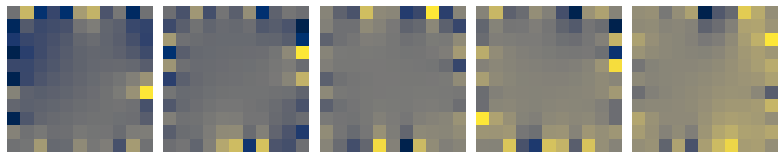

In [10]:
visualize([generate_harmonic(10, np.random.randn(36)) for i in range(5)], 10)

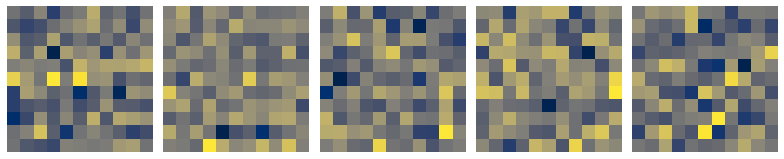

In [11]:
visualize([generate_nonharmonic(10) for i in range(5)], 10)

## Data Preparation

In [12]:
def harmonic_data_generator(n):
    while True:
        if np.random.rand() < .5:
            y = np.random.randn(4*(n-1))
            yield np.reshape(generate_harmonic(n,y), (n+1, n+1)).astype(np.float32), 1
        else:
            yield np.reshape(generate_nonharmonic(n), (n+1, n+1)).astype(np.float32), 0

In [13]:
def visualize_dataset(dataset, n, num_examples=5, cmap='cividis'):
    examples = [item for item in dataset.take(num_examples)]
    fig, axes = plt.subplots(1, num_examples, figsize=(n+1,n+1))
    axes = axes.flatten()
    for x, ax in zip(examples, axes):
        ax.imshow(x[0], cmap=cmap, vmin=-3, vmax=3)
        if x[1]:
            ax.set_title("Harmonic")
        else:
            ax.set_title("Nonharmonic")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [14]:
n=20
dataset = tf.data.Dataset.from_generator(harmonic_data_generator, 
                                         args=[n], 
                                         output_types=(tf.float32, tf.bool), 
                                         output_shapes = ((n+1,n+1), ()))

In [15]:
for item in dataset.take(2):
    pprint(item)

(<tf.Tensor: id=36, shape=(21, 21), dtype=float32, numpy=
array([[ 0.00000000e+00, -2.86463827e-01,  7.75416315e-01,
         6.37476683e-01,  2.83720255e-01, -1.60521016e-01,
        -8.68734777e-01,  2.22689107e-01, -5.51854432e-01,
        -6.72148108e-01, -3.95371407e-01,  2.14161962e-01,
        -3.38761300e-01, -1.85079477e-03, -1.84801245e+00,
         1.10947881e-02, -1.00409853e+00,  6.59667432e-01,
        -6.11156821e-01, -8.10502172e-02,  0.00000000e+00],
       [ 3.02626461e-01,  4.47382659e-01, -8.15012276e-01,
         1.38714147e+00,  1.40923679e+00,  1.01461470e+00,
         1.60536277e+00, -1.55451208e-01,  1.48682922e-01,
        -9.76577282e-01, -1.01316535e+00, -1.29806936e-01,
         1.66839886e+00, -1.03193510e+00,  3.66081208e-01,
        -9.20328975e-01,  1.37256786e-01, -7.22562850e-01,
        -9.51167226e-01,  3.42466801e-01,  3.56796086e-01],
       [ 2.22889876e+00, -3.13999861e-01,  5.18481195e-01,
        -2.41302489e-03,  2.23499879e-01,  2.41438627e-

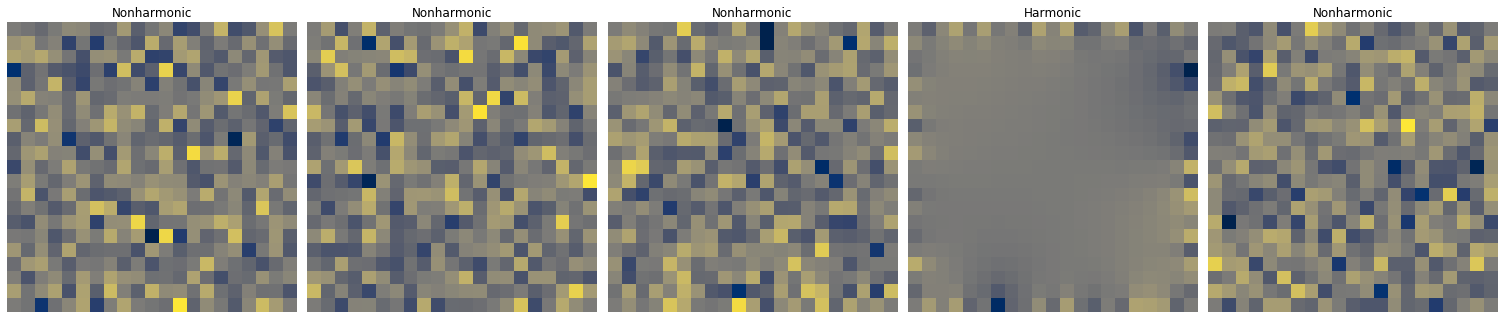

In [16]:
visualize_dataset(dataset, n, num_examples=5)

## Classifying Harmonic Functions. Expert Makes the Trained Net. $n=2$

Cheating: Giving the net the answer.  We need two nodes in the hidden layer with relu activations so that we can enforce that the value at the middle points is the average of the values at the surrounding points.  Each node penalizes the middle point for being either above or below the average.

In [17]:
n=2
dataset = tf.data.Dataset.from_generator(harmonic_data_generator, 
                                         args=[n], 
                                         output_types=(tf.float32, tf.bool), 
                                         output_shapes = ((n+1,n+1), ()))

dense_weights = np.array([[0., 0.],
                          [.25, -.25],
                          [0., 0.],
                          [.25, -.25],
                          [-1.,  1.],
                          [.25, -.25],
                          [0., 0.],
                          [.25, -.25],
                          [0., 0.]])
dense_bias = np.array([0., 0.])
                         
output_weights = np.array([-1000, -1000])
output_bias = np.array([10.])

In [18]:
dense_initializer = tf.keras.initializers.Constant(value=dense_weights)
dense_bias_initializer = tf.keras.initializers.Constant(value=dense_bias)
dense_layer = tf.keras.layers.Dense(2, 
                                    input_shape=(9,), 
                                    kernel_initializer=dense_initializer, 
                                    bias_initializer=dense_bias_initializer, 
                                    activation='relu')

In [19]:
output_initializer = tf.keras.initializers.Constant(value=output_weights)
output_bias_initializer = tf.keras.initializers.Constant(value=output_bias)
output_layer = tf.keras.layers.Dense(1, 
                                     kernel_initializer=output_initializer, 
                                     bias_initializer=output_bias_initializer,
                                     activation='sigmoid')

In [20]:
model = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(n+1,n+1)),
                             dense_layer, output_layer],
                             name="expert")

In [21]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "expert"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 9)                 0         
_________________________________________________________________
dense (Dense)                (None, 2)                 20        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 23
Trainable params: 23
Non-trainable params: 0
_________________________________________________________________


In [23]:
h = model.fit(dataset.batch(64), epochs=2, steps_per_epoch=10)

Train for 10 steps
Epoch 1/2
10/10 [==============================] - 1s 90ms/step - loss: 0.0331 - accuracy: 0.9953
Epoch 2/2
10/10 [==============================] - 0s 15ms/step - loss: 0.0421 - accuracy: 0.9937


As we can see, the net performs well immediately and has been unchanged by the training

In [34]:
model.layers[1].weights

[<tf.Variable 'dense/kernel:0' shape=(9, 2) dtype=float32, numpy=
 array([[ 0.        ,  0.        ],
        [ 0.2482706 , -0.25002673],
        [ 0.        ,  0.        ],
        [ 0.25034   , -0.24957444],
        [-1.0006437 ,  1.0002809 ],
        [ 0.25108224, -0.24949399],
        [ 0.        ,  0.        ],
        [ 0.2494172 , -0.25028685],
        [ 0.        ,  0.        ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(2,) dtype=float32, numpy=array([-0.00355929,  0.00305841], dtype=float32)>]

In [35]:
model.layers[2].weights

[<tf.Variable 'dense_1/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[-1000.0006],
        [ -999.9977]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([9.993296], dtype=float32)>]

## Classifying Harmonic Functions. Net has Minimal Nodes, $n=2$

Here we use the same structure of net as above, but with random initialization.  If run for enough time, it eventually solves the problem. If one of the hidden nodes figures out half of the mean value property, it results in a big, sudden jump in performance of the net. 

In this particular run, the jumps in performance are around Epochs 8 and 26.  After both jumps are made, I believe the improvement is the net gaining confidence in these nodes (the output weights increasing in magnitude).

In [24]:
n=2

In [25]:
dataset = tf.data.Dataset.from_generator(harmonic_data_generator, 
                                         args=[n], 
                                         output_types=(tf.float32, tf.bool), 
                                         output_shapes = ((n+1, n+1), ()))

In [26]:
dense_layer = tf.keras.layers.Dense(2, 
                                    input_shape=((n+1)**2,),
                                    activation='relu')

In [27]:
output_layer = tf.keras.layers.Dense(1,
                                     activation='sigmoid')

In [28]:
model = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(n+1,n+1)),
                             dense_layer, output_layer],
                            name="minimal")

In [29]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "minimal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 9)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 23
Trainable params: 23
Non-trainable params: 0
_________________________________________________________________


In [31]:
h = model.fit(dataset.batch(64), epochs=50, steps_per_epoch=100)

Train for 100 steps
Epoch 1/50
100/100 [==============================] - 2s 18ms/step - loss: 0.7431 - accuracy: 0.4936
Epoch 2/50
100/100 [==============================] - 1s 13ms/step - loss: 0.7151 - accuracy: 0.5056
Epoch 3/50
100/100 [==============================] - 1s 13ms/step - loss: 0.7001 - accuracy: 0.5280
Epoch 4/50
100/100 [==============================] - 1s 14ms/step - loss: 0.6806 - accuracy: 0.5680
Epoch 5/50
100/100 [==============================] - 1s 13ms/step - loss: 0.6659 - accuracy: 0.6023
Epoch 6/50
100/100 [==============================] - 1s 13ms/step - loss: 0.6414 - accuracy: 0.6488
Epoch 7/50
100/100 [==============================] - 1s 13ms/step - loss: 0.6219 - accuracy: 0.6733
Epoch 8/50
100/100 [==============================] - 1s 14ms/step - loss: 0.6066 - accuracy: 0.6897
Epoch 9/50
100/100 [==============================] - 1s 14ms/step - loss: 0.5914 - accuracy: 0.7056
Epoch 10/50
100/100 [==============================] - 1s 14ms/step - l

KeyboardInterrupt: 

## Analysis of Net Weights

Assuming convergence happens (I have seen it fail to converge in 100 epochs at least once), we can see that both sides of the mean value property have been learned.  See the weights of the hidden layer and output layer.

Indices 1,3,5,7 of the hidden layer are equal and add up to the negative of the 4th index.  The two nodes are either pointing in opposite directions or are given opposite weights in the output layer.

In [32]:
model.layers[1].weights

[<tf.Variable 'dense_2/kernel:0' shape=(9, 2) dtype=float32, numpy=
 array([[-0.19597948,  0.38713008],
        [-0.4751342 ,  0.5995144 ],
        [-0.44297752, -0.47761548],
        [-0.47493705,  0.59817886],
        [ 1.8965907 , -2.3992684 ],
        [-0.4743856 ,  0.5994377 ],
        [-0.37350753, -0.58541626],
        [-0.4726985 ,  0.5995223 ],
        [-0.73649824, -0.23219943]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(2,) dtype=float32, numpy=array([-0.00101611, -0.00020503], dtype=float32)>]

In [33]:
model.layers[2].weights

[<tf.Variable 'dense_3/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[-2.0161135],
        [-2.3323162]], dtype=float32)>,
 <tf.Variable 'dense_3/bias:0' shape=(1,) dtype=float32, numpy=array([1.0829649], dtype=float32)>]

## Classifying Harmonic Functions. Net has Many Nodes, $n=2$

This net has been given a substantially larger hidden layer.  This results in many more chances for the net to stumble across the mean value property leading to much faster convergence.  Here confidence in the property can be established by having many more nodes encode the same information, whereas above it could only be expressed with larger values in the output layer.

In [34]:
n=2

In [35]:
dataset = tf.data.Dataset.from_generator(harmonic_data_generator, 
                                         args=[n], 
                                         output_types=(tf.float32, tf.bool), 
                                         output_shapes = ((n+1,n+1), ()))

In [36]:
dense_layer = tf.keras.layers.Dense(32, 
                                    input_shape=(((n+1)**2,)),
                                    activation='relu',
                                    kernel_regularizer=tf.keras.regularizers.l1(.001))

In [37]:
output_layer = tf.keras.layers.Dense(1,
                                     activation='sigmoid')

In [38]:
model = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(n+1,n+1)), 
                             dense_layer, output_layer],
                            name='dense_n2')

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [40]:
print(model.summary())

Model: "dense_n2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 9)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
h = model.fit(dataset.batch(64), epochs=20, steps_per_epoch=100)

Train for 100 steps
Epoch 1/20
100/100 [==============================] - 2s 18ms/step - loss: 0.7312 - accuracy: 0.5469
Epoch 2/20
100/100 [==============================] - 1s 13ms/step - loss: 0.6738 - accuracy: 0.7042
Epoch 3/20
100/100 [==============================] - 1s 14ms/step - loss: 0.6021 - accuracy: 0.8202
Epoch 4/20
100/100 [==============================] - 1s 14ms/step - loss: 0.5238 - accuracy: 0.8569
Epoch 5/20
100/100 [==============================] - 1s 14ms/step - loss: 0.4493 - accuracy: 0.8813
Epoch 6/20
100/100 [==============================] - 1s 14ms/step - loss: 0.4025 - accuracy: 0.8884
Epoch 7/20
100/100 [==============================] - 1s 13ms/step - loss: 0.3597 - accuracy: 0.8973
Epoch 8/20
100/100 [==============================] - 1s 14ms/step - loss: 0.3349 - accuracy: 0.9036
Epoch 9/20
100/100 [==============================] - 1s 15ms/step - loss: 0.3131 - accuracy: 0.9081
Epoch 10/20
 81/100 [=======================>......] - ETA: 0s - loss: 

KeyboardInterrupt: 

## Analysis of Net Weights

Examining the output layer, it is clear that some nodes in the hidden layer are treated as important (weights around -5) some are not (weights around 0).  

Question: Why are all of the important weights here negative, whereas this didn't happen above?

In [42]:
model.layers[2].get_weights()

[array([[ 0.4373489 ],
        [ 0.4265884 ],
        [ 0.19957417],
        [-1.214467  ],
        [-1.0523483 ],
        [-0.01274417],
        [ 0.4634423 ],
        [ 0.3420575 ],
        [ 0.20284633],
        [-0.7723524 ],
        [ 0.26793593],
        [ 0.20076196],
        [ 0.22526865],
        [-1.0428467 ],
        [-0.0787764 ],
        [-1.1540365 ],
        [ 0.40062064],
        [-0.14682026],
        [ 0.10149509],
        [ 0.5222983 ],
        [-0.8341928 ],
        [-0.90779483],
        [-0.96090275],
        [-0.7765352 ],
        [ 0.00534577],
        [-0.7254577 ],
        [-0.7939792 ],
        [-0.7772236 ],
        [-0.00251376],
        [-0.52052414],
        [ 0.33168232],
        [-0.92372096]], dtype=float32), array([0.23660968], dtype=float32)]

If we pick an important node in the first layer, it will encode one side of the mean-value condition, as above.  Thanks the l1 regularization, we have 0's (approximately) in the degenerate indices 0, 2, 6, and 8.

<BarContainer object of 9 artists>

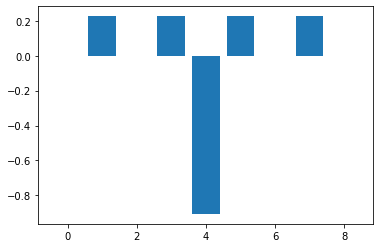

In [48]:
plt.bar(np.arange(9), model.layers[1].kernel.numpy()[:,3])

## Classifying Harmonic Functions, $n>2$

Naive.  The net can very quickly separate the harmonic functions from the random negatives with fantastic accuracy, however, constructed counterexamples that are nearly harmonic will still fool it.

In [55]:
n=5

In [56]:
dataset = tf.data.Dataset.from_generator(harmonic_data_generator, 
                                         args=[n], 
                                         output_types=(tf.float32, tf.bool), 
                                         output_shapes = ((n+1,n+1), ()))

In [57]:
dense_layer = tf.keras.layers.Dense(12 * (n-1)**2, 
                                    input_shape=((n+1)**2,),
                                    activation='relu')

In [58]:
output_layer = tf.keras.layers.Dense(1,
                                     activation='sigmoid')

In [59]:
model = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(n+1,n+1)), 
                             dense_layer, output_layer],
                            name='dense_nlarge')

In [60]:
model.compile(optimizer='adam',
              loss='hinge',
              metrics=['accuracy'])

In [61]:
print(model.summary())

Model: "dense_nlarge"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 36)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 192)               7104      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 193       
Total params: 7,297
Trainable params: 7,297
Non-trainable params: 0
_________________________________________________________________
None


In [62]:
h = model.fit(dataset.batch(64), epochs=10, steps_per_epoch=100)

Train for 100 steps
Epoch 1/10
100/100 [==============================] - 2s 20ms/step - loss: 0.9076 - accuracy: 0.7248
Epoch 2/10
100/100 [==============================] - 1s 15ms/step - loss: 0.6600 - accuracy: 0.9956
Epoch 3/10
100/100 [==============================] - 2s 15ms/step - loss: 0.5464 - accuracy: 0.9995
Epoch 4/10
100/100 [==============================] - 1s 15ms/step - loss: 0.5166 - accuracy: 0.9997
Epoch 5/10
100/100 [==============================] - 1s 15ms/step - loss: 0.5231 - accuracy: 0.9995
Epoch 6/10
100/100 [==============================] - 1s 15ms/step - loss: 0.5089 - accuracy: 0.9998
Epoch 7/10
100/100 [==============================] - 2s 20ms/step - loss: 0.5103 - accuracy: 0.9998
Epoch 8/10
100/100 [==============================] - 2s 17ms/step - loss: 0.5005 - accuracy: 0.9998
Epoch 9/10
100/100 [==============================] - 1s 15ms/step - loss: 0.5074 - accuracy: 0.9998
Epoch 10/10
100/100 [==============================] - 1s 15ms/step - l

## Counterexample

It actually does become a little less certain however!

In [63]:
x = generate_nonharmonic(5)

In [64]:
model.predict(x.reshape(1,6,6))

array([[0.00035066]], dtype=float32)

In [65]:
x = generate_harmonic(5, np.random.randn(36))

In [66]:
model.predict(x.reshape(1,6,6))

array([[0.99802506]], dtype=float32)

In [67]:
x[1,1] = 0
is_harmonic(x, 5)

False

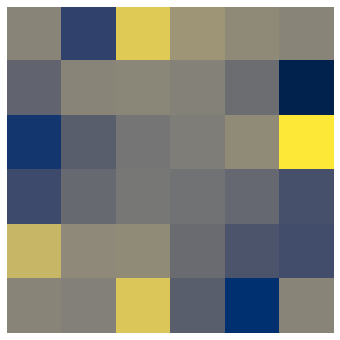

In [68]:
visualize([x], n)

In [69]:
model.predict(x.reshape(1,6,6))

array([[0.98481697]], dtype=float32)

## More Extreme

In [70]:
for i in range(1,5):
    for j in range(1,5):
        x[i,j] = 0
is_harmonic(x, 5)

False

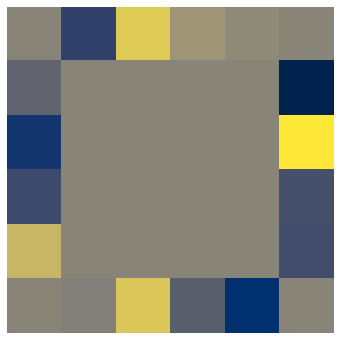

In [71]:
visualize([x], n)

In [72]:
model.predict(x.reshape(1,6,6))

array([[0.654376]], dtype=float32)

## Using a Convolutional Net.

Doesn't actually resolve the above problem.

In [73]:
n=5

In [74]:
dataset = tf.data.Dataset.from_generator(harmonic_data_generator, 
                                         args=[n], 
                                         output_types=(tf.float32, tf.bool), 
                                         output_shapes = ((n+1,n+1), ()))

In [75]:
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((n+1,n+1,1), input_shape=(n+1,n+1)),
    tf.keras.layers.Conv2D(32, 
                           kernel_size=3,
                           input_shape=(n+1, n+1, 1),
                           activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l1(.001)),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(1, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
], name="Conv2D-1")

In [76]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [77]:
print(model.summary())

Model: "Conv2D-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 6, 6, 1)           0         
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 4, 32)          320       
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 32)          0         
_________________________________________________________________
dense_8 (Dense)              (None, 4, 4, 1)           33        
_________________________________________________________________
flatten_4 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 370
Trainable params: 370
Non-trainable params: 0
____________________________________________________________

In [78]:
h = model.fit(dataset.batch(64), epochs=10, steps_per_epoch=100)

Train for 100 steps
Epoch 1/10
100/100 [==============================] - 2s 24ms/step - loss: 0.7134 - accuracy: 0.5536
Epoch 2/10
100/100 [==============================] - 2s 15ms/step - loss: 0.6597 - accuracy: 0.6419
Epoch 3/10
100/100 [==============================] - 2s 18ms/step - loss: 0.5565 - accuracy: 0.7394
Epoch 4/10
100/100 [==============================] - 2s 18ms/step - loss: 0.4584 - accuracy: 0.8239
Epoch 5/10
100/100 [==============================] - 2s 18ms/step - loss: 0.3737 - accuracy: 0.9114
Epoch 6/10
100/100 [==============================] - 2s 18ms/step - loss: 0.3187 - accuracy: 0.9497
Epoch 7/10
100/100 [==============================] - 2s 16ms/step - loss: 0.2854 - accuracy: 0.9706
Epoch 8/10
100/100 [==============================] - 2s 16ms/step - loss: 0.2562 - accuracy: 0.9833
Epoch 9/10
100/100 [==============================] - 2s 17ms/step - loss: 0.2323 - accuracy: 0.9880
Epoch 10/10
100/100 [==============================] - 2s 17ms/step - l

## The Same Problem, Partially Solved

In [94]:
x = generate_nonharmonic(5)

In [95]:
model.predict(x.reshape(1,6,6))

array([[0.26326767]], dtype=float32)

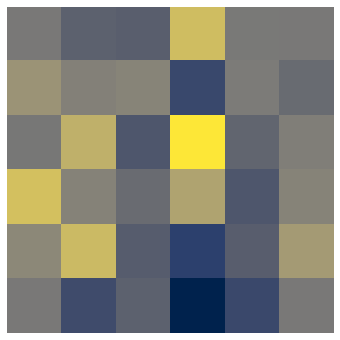

In [96]:
visualize([x], n)

In [98]:
x = generate_harmonic(5, np.random.randn(36))

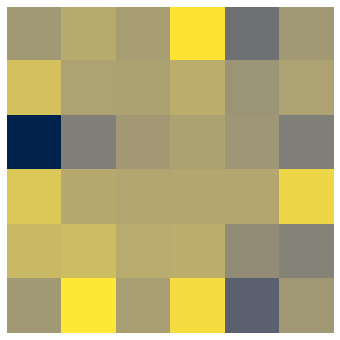

In [99]:
visualize([x], n)

In [82]:
model.predict(x.reshape(1,6,6))

array([[0.9863624]], dtype=float32)

In [100]:
x[1,1] = 0
is_harmonic(x, 5)

False

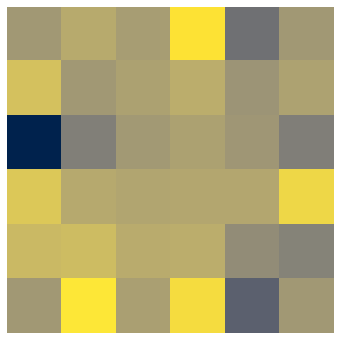

In [101]:
visualize([x], n)

In [102]:
model.predict(x.reshape(1,6,6))

array([[0.97733647]], dtype=float32)

In [103]:
for i in range(1,5):
    for j in range(1,5):
        x[i,j] = 0
is_harmonic(x, 5)

False

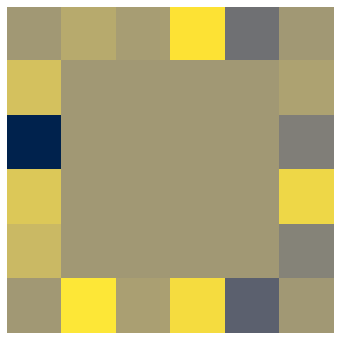

In [104]:
visualize([x], n)

In [105]:
model.predict(x.reshape(1,6,6))

array([[0.92701256]], dtype=float32)

In [89]:
for i in range(1,5):
    for j in range(1,5):
        x[i,j] = 0
x[2,2] = 1.
is_harmonic(x, 5)

False

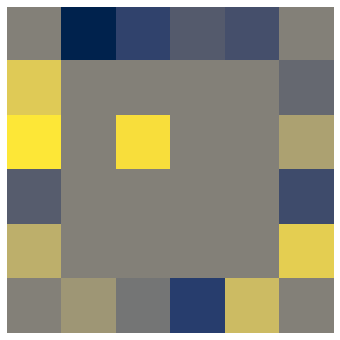

In [90]:
visualize([x], n)

In [91]:
model.predict(x.reshape(1,6,6))

array([[0.86443824]], dtype=float32)

## The Weights

Sometimes we see the equation beginning to come out in some of the more important weights, but it is not insisted upon by the output layer.

Other times we do not get the equation at all.

In [92]:
model.layers[3].get_weights()

[array([[-0.746314  ],
        [ 0.2165318 ],
        [ 0.27200243],
        [-0.5717236 ],
        [-0.88819605],
        [-0.7569457 ],
        [-0.8701737 ],
        [-0.8280202 ],
        [ 0.30984902],
        [-0.62134653],
        [ 0.2325628 ],
        [ 0.34803176],
        [-0.72084916],
        [ 0.29815093],
        [-0.7498163 ],
        [ 0.23683754],
        [ 0.23098241],
        [ 0.35125038],
        [ 0.29068446],
        [ 0.22140238],
        [ 0.20059063],
        [-0.726321  ],
        [ 0.24850032],
        [-0.772085  ],
        [ 0.18709631],
        [-0.76698196],
        [-0.74630433],
        [-0.89588106],
        [ 0.25272763],
        [-0.87703025],
        [ 0.23969646],
        [ 0.22653413]], dtype=float32), array([0.27313077], dtype=float32)]

In [93]:
model.layers[1].get_weights()[0][:,:,:,15]

array([[[ 1.9714033e-05],
        [-6.7443177e-03],
        [ 2.0723348e-03]],

       [[-4.8634727e-03],
        [ 2.8734305e-03],
        [ 6.0827937e-04]],

       [[ 6.9433701e-04],
        [ 5.2538054e-04],
        [ 1.7046751e-03]]], dtype=float32)